<a href="https://colab.research.google.com/github/varunchitturi/Algorithmic-Stock-Trader/blob/main/Generative_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.5 MB/s eta 0:00:00


In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from diffusers import DDPMPipeline
import random

In [4]:
from torch.utils.data import DataLoader, Subset
# Image normalization
# Converts the image into a tensor and normalizes to acheive a mean of 0 and variance of 1
transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# Download MNIST train and test set and normalize images
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)

subset_size = int(0.016 * len(train_set))
indices = torch.randperm(len(train_set))[:subset_size]
train_set = Subset(train_set, indices)

subset_size = int(0.096 * len(test_set))
indices = torch.randperm(len(test_set))[:subset_size]
test_set = Subset(test_set, indices)

# Define train and test dataloaders, used to get batches sequentially
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35381536.43it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1216576.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9237323.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6960368.57it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
def add_noise(alpha_t, x, t):
    epsilon = torch.randn(x.shape)
    alpha_bar_t = alpha_t ** t
    noisy_image = np.sqrt(alpha_bar_t) * x  + (1 - alpha_bar_t) * epsilon

    return noisy_image

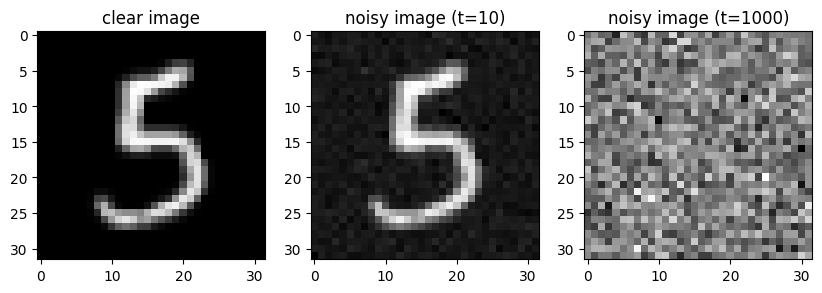

In [6]:
sample_image = train_set[0][0]

# Make a noisy image
epsilon = torch.randn_like(sample_image)
alpha_t = 0.99
noisy_image = add_noise(alpha_t, sample_image, 10)
more_noisy_image = add_noise(alpha_t, sample_image, 1000)

# Plot the clear image and the noisy image
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample_image.squeeze(0), cmap='gray')
axs[0].set_title('clear image')
axs[1].imshow(noisy_image.squeeze(0), cmap='gray')
axs[1].set_title('noisy image (t=10)')
axs[2].imshow(more_noisy_image.squeeze(0), cmap='gray')
axs[2].set_title('noisy image (t=1000)')
plt.show()

In [7]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

lossTrain = []
lossTest = []

num_epochs = 5

for epoch in range(num_epochs):
    train_loss_epoch = 0.
    test_loss_epoch = 0.

    for data, target in train_loader:
        # Set model in training mode
        model.train()

        # Generate a random timestep for each image
        t = torch.randint(2, 1000, size=(32,))
        alpha_t = 0.99

        # Add noise to the batch of images
        noisy_data = torch.empty_like(data)
        for i in range(data.size(0)):
            noisy_data[i] = add_noise(alpha_t, data[i], t[i])

        # Compute batch predictions
        noise_pred = model(noisy_data, t, return_dict=False)[0]

        # Compute loss
        train_loss = F.mse_loss(noise_pred, data)

        # Compute gradients of loss w respect to current params
        train_loss.backward()

        # Update params using SGD
        optimizer.step()

        # Accumulate batch losses
        train_loss_epoch += train_loss.item()

        # Clear gradients of previous batch
        optimizer.zero_grad()

    # Update learning rate
    lr_scheduler.step()

    for data, target in train_loader:
        # Set the model to evaluation mode.
        model.eval()
        with torch.no_grad():
            # Generate a random timestep for each image
            t = torch.randint(2, 1000, size=(32,))
            alpha_t = 0.99

            # Add noise to the batch of images
            noisy_data = torch.empty_like(data)
            for i in range(data.size(0)):
                noisy_data[i] = add_noise(alpha_t, data[i], t[i])

            # Compute batch predictions
            noise_pred = model(noisy_data, t, return_dict=False)[0]

            # Compute loss
            test_loss = F.mse_loss(noise_pred, data)
            test_loss_epoch += test_loss.item()

    lossTrain.append(train_loss_epoch/len(train_loader))
    lossTest.append(test_loss_epoch/len(test_loader))

    print(f"Epoch: {epoch} \t Train Loss: {train_loss_epoch/len(train_loader):.3f} \t TestLoss: {test_loss_epoch/len(test_loader):.3f}")
print(f"Final Training Loss: {lossTrain[-1]:.2f}")
print(f"Final Test Loss: {lossTest[-1]:.2f}")

In [ ]:
# Generating images
noise = torch.randn([1, 1, 32, 32])
generated_images = []

model.eval()
num_timesteps_list = [random.randint(500, 1000) for _ in range(10)]
alpha_t = 0.99
with torch.no_grad():
    for num_timesteps in num_timesteps_list:
        x_t = torch.randn([1, 1, 32, 32])
        for t in reversed(range(1, num_timesteps)):
            timestep = torch.tensor([t/num_timesteps])
            x_theta = model(x_t, timestep, return_dict=False)[0]
            alpha_bar_t = alpha_t ** t
            alpha_bar_t_1 = alpha_t ** (t-1)
            x_t = 1 / (1 - alpha_bar_t) * (np.sqrt(alpha_t) * (1 - alpha_bar_t_1) * x_t + np.sqrt(alpha_bar_t_1) * (1 - alpha_t) * x_theta)
        generated_images.append(x_t.squeeze().squeeze().numpy())

# Visualize the output
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Generated image {idx + 1}')
plt.show()